```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2018  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from netCDF4 import Dataset
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

#Set large figure sizes
plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, WindStress, IPythonMagic

#Import initial condition and bathymetry generating functions:
from SWESimulators import BathymetryAndICs as bic

In [2]:
%setup_logging realistic_sim.log
%cuda_context_handler gpu_ctx

Registering logging to realistic_sim.log
Python version 3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
PyCUDA version 2017.1.1
CUDA version (9, 1, 0)
Driver version 9010
Using 'GeForce 840M' GPU
Created context handle <858471396256>


In [3]:
# Read netCDF data through THREDDS server
verbose = False
nordik4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'

with Common.Timer("land_download") as t:
    with Dataset(nordik4km_url) as ncfile:

        if (verbose):
            print("Variables")
            for var in ncfile.variables:
                print(var)

            print ("Attributes:")    
            for attr in ncfile.ncattrs():
                print(attr, ": ", ncfile.getncattr(attr))

        H_full = np.array(ncfile.variables['h'])

        print("H range: ", np.min(H_full), np.max(H_full))
print("Downloaded in {:f} seconds".format(t.secs))

H range:  10.0 4810.0
Downloaded in 7.305940 seconds


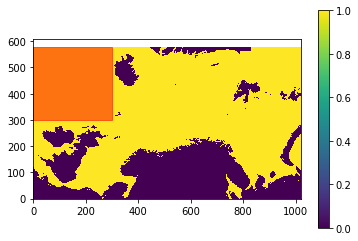

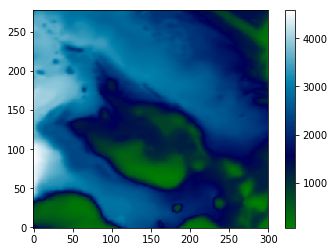

In [4]:
#Set extent of what we want to get of bathymetry
x0 = 0
x1 = 300

y0 = 300
y1 = 578

fig = plt.figure()
land = np.where(H_full > 15, 1.0, 0.0)
plt.imshow(land, interpolation="None", origin='lower')
fig.gca().fill([x0, x0, x1, x1], [y0, y1, y1, y0], fill=True, linestyle='-', color='red', alpha=0.5)
plt.colorbar()


H = H_full[y0:y1, x0:x1]
fig = plt.figure()
plt.imshow(H, interpolation="None", origin='lower', cmap='ocean')
plt.colorbar()

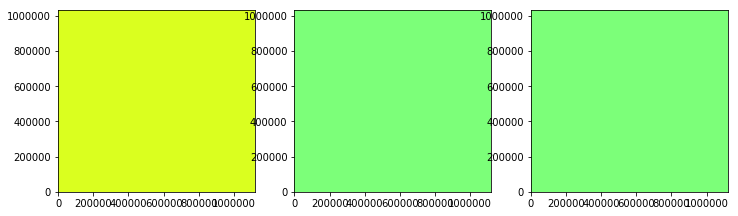

In [5]:
ghost_cells = [10, 10, 10, 10]
ny = H.shape[0] - ghost_cells[0] - ghost_cells[2]
nx = H.shape[1] - ghost_cells[1] - ghost_cells[3]
dx = 4000
dy = 4000

data_shape = (ny + ghost_cells[0] + ghost_cells[2], nx + ghost_cells[1] + ghost_cells[3])
boundary_conditions = Common.BoundaryConditions(3,3,3,3, spongeCells=ghost_cells)

eta0 = np.zeros(data_shape, dtype=np.float32, order='C');
hu0 = np.zeros((data_shape[0], data_shape[1]+1), dtype=np.float32, order='C');
hv0 = np.zeros((data_shape[0]+1, data_shape[1]), dtype=np.float32, order='C');

#bic.addBump(eta0, nx, ny, dx, dy, 0.2, 0.2, 2000, ghost_cells)

plt.figure(figsize=(12, 8))

domain_extent = [0, nx*dx, 0, ny*dy]

ax_eta = plt.subplot(1,3,1)
sp_eta = ax_eta.imshow(eta0, interpolation="none", origin='bottom', vmin=-1.5, vmax=1.5, extent=domain_extent, cmap='gist_ncar')

ax_u = plt.subplot(1,3,2)
sp_u = ax_u.imshow(hu0, interpolation="none", origin='bottom', vmin=-5, vmax=5, extent=domain_extent, cmap='jet')

ax_v = plt.subplot(1,3,3)
sp_v = ax_v.imshow(hv0, interpolation="none", origin='bottom', vmin=-5, vmax=5, extent=domain_extent, cmap='jet')

Array shapes:  (2, 1, 949, 889) (2, 1, 949, 889)
X wind range:  -10.442474 23.215729
X wind range:  -11.581279 16.707626
Downloaded in 9.845219 seconds


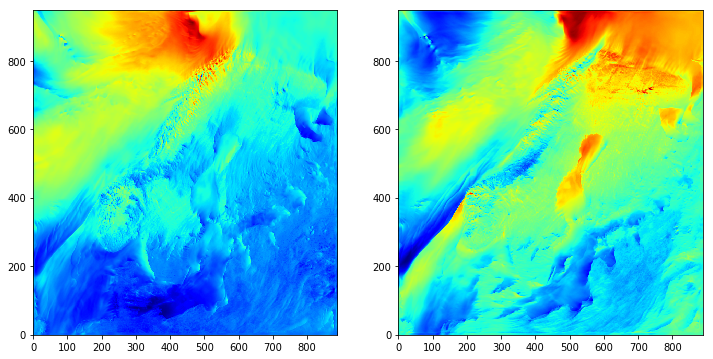

In [6]:
# Read netCDF data through THREDDS server
meps25_url = 'http://thredds.met.no/thredds/dodsC/meps25files/meps_det_extracted_2_5km_latest.nc'
#meps25_url = 'http://thredds.met.no/thredds/dodsC/meps25files/meps_det_extracted_2_5km_20180829T12Z.nc'
#arome_url = 'http://thredds.met.no/thredds/dodsC/aromearcticlatest/arome_arctic_vc_2_5km_latest.nc'
#arome_url = 'http://thredds.met.no/thredds/dodsC/aromearcticlatest/arome_arctic_extracted_2_5km_20180830T00Z.nc'
timesteps = [1, 2]
verbose = False
with Common.Timer("wind_download") as t:
    with Dataset(meps25_url) as ncfile:

        if (verbose):
            print("Variables")
            for var in ncfile.variables:
                print(var)

            print ("Attributes:")    
            for attr in ncfile.ncattrs():
                print(attr, ": ", ncfile.getncattr(attr))

        # These are [timestep, level, lon, lat]
        #w_x = np.array(ncfile.variables['x_wind_10m'][timesteps])
        #w_y = np.array(ncfile.variables['y_wind_10m'][timesteps])
        
        w_x = np.array(ncfile.variables['x_wind_10m'][timesteps])
        w_y = np.array(ncfile.variables['y_wind_10m'][timesteps])
        
        
        
        print("Array shapes: ", w_x.shape, w_y.shape)
        print("X wind range: ", np.min(w_x), np.max(w_x))
        print("X wind range: ", np.min(w_y), np.max(w_y))
        
print("Downloaded in {:f} seconds".format(t.secs))


fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(w_x[0,0,:,:], interpolation="None", origin='lower', cmap='jet')
plt.subplot(1,2,2)
plt.imshow(w_y[0,0,:,:], interpolation="None", origin='lower', cmap='jet')

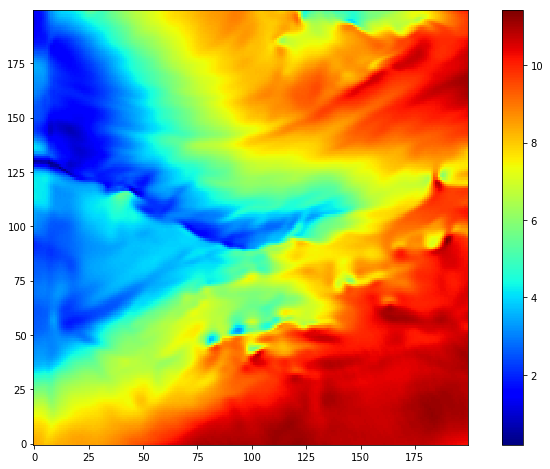

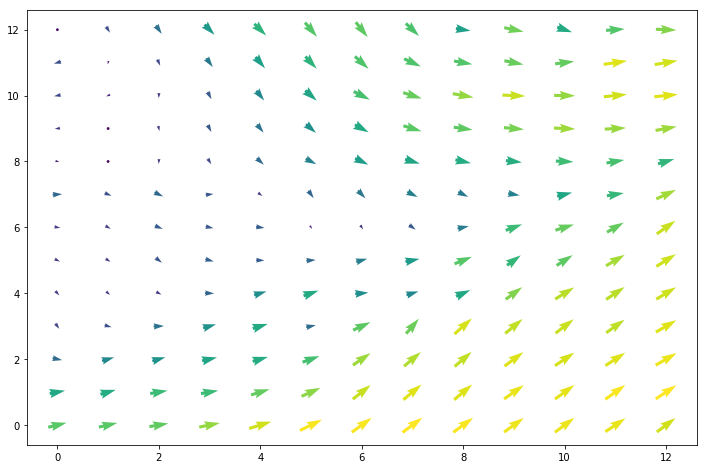

In [7]:
timestep = 0
level = 0
x0, y0 = 0, 600
x1, y1 = 200, 800

x = w_x[:,level,y0:y1,x0:x1];
y = w_y[:,level,y0:y1,x0:x1];

if False:
    x = np.zeros((2,200,200))
    y = np.zeros((2,200,200))
    xx = np.linspace(-1, 1, 200)
    yy = np.linspace(-1, 1, 200)
    x[0], y[0] = np.meshgrid(5*np.cos(np.abs(np.pi*xx)), 5*np.cos(np.abs(np.pi*yy)))
    x[1], y[1] = np.meshgrid(-5*np.cos(np.abs(np.pi*xx)), -5*np.cos(np.abs(np.pi*yy)))

    x = x.astype(np.float32)
    y = y.astype(np.float32)

wind_speed = np.sqrt(x*x + y*y)

fig = plt.figure(figsize=(12,8))
plt.imshow(wind_speed[0], interpolation="None", origin='lower', cmap='jet')
plt.colorbar()

fig = plt.figure(figsize=(12, 8))
ss=16
plt.quiver(x[0, ::ss,::ss], y[0, ::ss, ::ss], wind_speed[0, ::ss, ::ss], pivot='mid', units='width', scale=300)

In [8]:
# C_drag as defined by Engedahl (1995)
#(See "Documentation of simple ocean models for use in ensemble predictions. Part II: Benchmark cases"
#at https://www.met.no/publikasjoner/met-report/met-report-2012 for details.) /
# FIXME: This cannot be right?? 
#const float C_drag = (wind_stress->windspeed < 11) ? 0.0012f : (0.49f + 0.065f)*wind_stress->wind_speed;

t = [0, 24*3600]
#Scale wind to get wind stress estimate
x = x * 0.0012
y = x * 0.0012
wind_stress = WindStress.WindStress(t=t, X=x, Y=y)

In [9]:
# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "H": H,
    "eta0": eta0,
    "hu0": hu0,
    "hv0": hv0,
    "nx": nx, "ny": ny,
    "dx": dx, "dy": dy,
    "dt": 2.5,
    "g": 9.81,
    "f": 0.0004,
    "r": 0.0,
    "A": 0.5*dx,
    "boundary_conditions": boundary_conditions,
    "wind_stress": wind_stress
}


for key, value in sim_args.items():
    print("{:s} = {:s}".format(key, str(value)))

gpu_ctx = CudaContext id 858471396256
H = [[1686. 1659. 1622. ...  199.  192.  188.]
 [1560. 1538. 1505. ...  197.  187.  181.]
 [1403. 1386. 1361. ...  198.  187.  179.]
 ...
 [3272. 3276. 3293. ... 1203. 1183. 1163.]
 [3287. 3286. 3294. ... 1221. 1201. 1182.]
 [3305. 3302. 3304. ... 1236. 1216. 1198.]]
eta0 = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
hu0 = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
hv0 = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
nx = 280
ny = 258
dx = 4000
dy = 4000
dt = 2.5
g = 9.81
f = 0.0004
r = 0.0
A = 2000.0
boundary_conditions = north: Flow Relaxation Scheme, east: Flow Relaxation Scheme, south: Flow Relaxation Scheme, west: F

In [10]:
sim = CTCS.CTCS(**sim_args)

self.interior_domain_indices: [-10 -10  10  10]


In [11]:
def sim_animation(simulator, t_end, n):
    eta1, u1, v1 = sim.download(interior_domain_only=True)
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(12, 8))
    domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
    
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta1, interpolation="none", origin='bottom', vmin=-0.05, vmax=0.05, extent=domain_extent, cmap='gist_ncar')
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(u1, interpolation="none", origin='bottom', vmin=-2.5, vmax=2.5, extent=domain_extent, cmap='jet')
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(v1, interpolation="none", origin='bottom', vmin=-2.5, vmax=2.5, extent=domain_extent, cmap='jet')
    
    #Helper function which simulates and plots the solution
    def animate(i):
        if (i>0):
            t = sim.step(t_end/float(n))
        else:
            t = sim.t
        eta1, u1, v1 = sim.download(interior_domain_only=True)
        
        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)
        
        fig.sca(ax_u)
        sp_u.set_data(u1)
        
        fig.sca(ax_v)
        sp_v.set_data(v1)
        
        fig.suptitle("Time = {:04.1f} H ({:s})".format(t/3600, sim.__class__.__name__), fontsize=18)
        print(".", end='')

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(n), interval=100)
    plt.close(fig)
    return anim

In [ ]:
# Make sure not to commit output from this simulation to git:
#sim_animation(sim, t_end=3600*24, n=50)